# Apr ??th, 2022 ()

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
set_style()

## Fig dir

In [2]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice(128)
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

remove = [
    n for n, lbl in gr_ca.n2l.items()
    if lbl not in gr_bold.n2l.values()
]
include = np.delete(np.arange(len(gr_ca.n2l)), remove)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi[:, include],
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

## Load parcel

In [5]:
f = 'parcel2d-flat_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_flat = ants.image_read(f, pixeltype='unsigned int')
parcel_flat = parcel_flat.numpy()

f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_top = ants.image_read(f, pixeltype='unsigned int')
parcel_top = parcel_top.numpy()

## Mk affil

In [6]:
%%time
affil, affil_included = gr_ca.node_affiliations()

CPU times: user 13.2 s, sys: 89.4 ms, total: 13.3 s
Wall time: 13.3 s


In [7]:
list(affil)

[
    'cmap',
    'colors',
    'obj_top',
    'obj_flat',
    'aff_top',
    'aff_flat',
    'regions_l',
    'regions_r',
    'affiliation',
    'regions_affil',
    'regions_affil_max'
]

<matplotlib.image.AxesImage object at 0x7f7e8a7ce0d0>

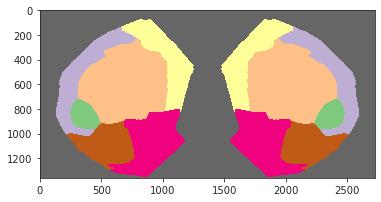

In [8]:
plt.imshow(affil['aff_flat'], cmap='Accent_r')

<matplotlib.image.AxesImage object at 0x7f7e8a703fa0>

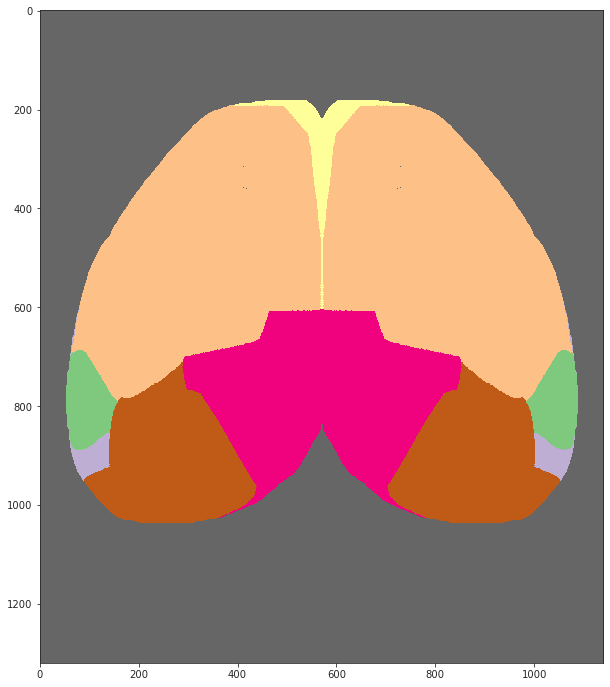

In [9]:
plt.figure(figsize=(15, 12))
plt.imshow(affil['aff_top'], cmap='Accent_r')

In [10]:
aaa = dc(affil['obj_flat'])
for i, idx in enumerate(np.unique(affil['obj_flat'][affil['obj_flat'].nonzero()])):
    aaa[affil['obj_flat'] == idx] = i + 1
bbb = dc(affil['obj_top'])
for i, idx in enumerate(np.unique(affil['obj_top'][affil['obj_top'].nonzero()])):
    bbb[affil['obj_top'] == idx] = i + 1

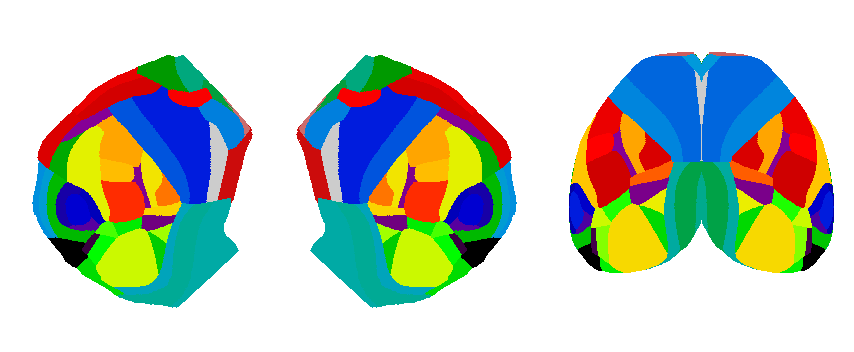

In [11]:
fig, axes = create_figure(1, 2, figsize=(12, 5), width_ratios=[1.8, 1])
axes[0].imshow(mwh(aaa == 0, aaa), cmap='nipy_spectral_r')
axes[1].imshow(mwh(bbb == 0, bbb), cmap='nipy_spectral_r')
remove_ticks(axes)

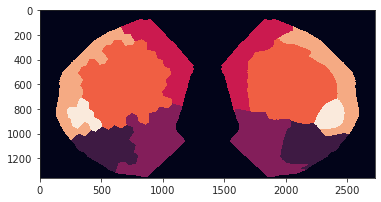

In [12]:
affil_max_flat = np.zeros_like(parcel_flat)
for r, af in affil['regions_affil_max'].items():
    affil_max_flat[parcel_flat == r] = list(affil['affiliation']).index(af) + 1

m = np.isin(parcel_flat, affil['regions_r'])
affil_max_flat[m] = affil['aff_flat'][m]
affil_max_flat[parcel_flat == 0] = 0
plt.imshow(affil_max_flat);

In [13]:
regions_included = [
    mice.parcel.encode(1, int(lbl.split('-')[1]), 0)
    for lbl in gr_ca.l2n
]
regions_included = np.array(regions_included)
regions_included = regions_included[gr_ca.l_ids]

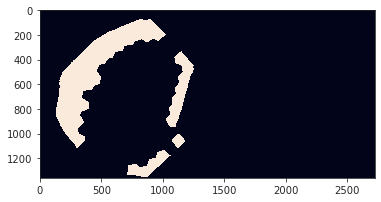

In [14]:
mask_f = np.zeros(parcel_flat.shape)
mask_f[np.isin(parcel_flat, affil['regions_l'])] = 1
mask_f[np.isin(parcel_flat, regions_included)] = 0
plt.imshow(mask_f);

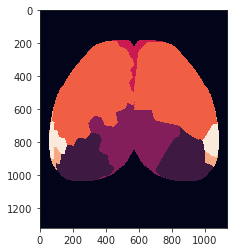

In [15]:
affil_max_top = np.zeros_like(parcel_top)
for r, af in affil['regions_affil_max'].items():
    affil_max_top[parcel_top == r] = list(affil['affiliation']).index(af) + 1

m = np.isin(parcel_top, affil['regions_r'])
affil_max_top[m] = affil['aff_top'][m]
affil_max_top[parcel_top == 0] = 0
plt.imshow(affil_max_top);

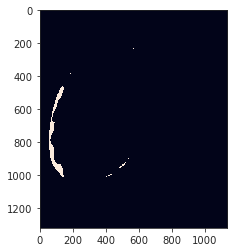

In [16]:
mask_t = np.zeros(parcel_top.shape)
mask_t[np.isin(parcel_top, affil['regions_l'])] = 1
mask_t[np.isin(parcel_top, regions_included)] = 0
plt.imshow(mask_t);

In [17]:
mf_tr, f_tr = filter_boundaries([mask_f, affil_max_flat], mask=affil_max_flat)
mt_tr, t_tr = filter_boundaries([mask_t, affil_max_top], mask=affil_max_top)

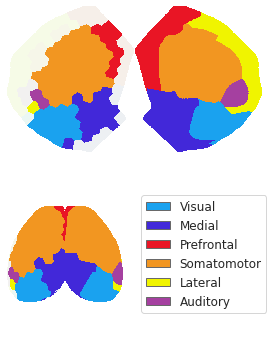

In [18]:
fig = plt.figure(figsize=(4, 5), tight_layout=True)
gs = GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
x2p = mwh(f_tr == 0, f_tr)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mf_tr == 0, mf_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, 0])
x2p = filter_boundaries(t_tr, t_tr)
x2p = mwh(x2p == 0, x2p)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mt_tr == 0, mt_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, 1])
legend_elements = [
    matplotlib.patches.Patch(facecolor=c, edgecolor='dimgrey', label=lbl)
    for lbl, c in affil['colors'].items()
]
leg = ax.legend(handles=legend_elements, fontsize=12, loc='center')
remove_ticks(ax)

#### Boundary plots

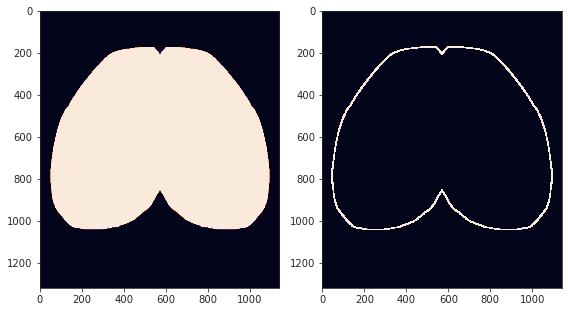

In [19]:
x = (parcel_top > 0).astype(float)
x = sp_img.gaussian_filter(x, sigma=1)
x = (x > 0).astype(float)
x = sp_img.gaussian_filter(x, sigma=0.75)
contour = ~np.logical_or(
    sp_img.sobel(x, axis=0),
    sp_img.sobel(x, axis=1),
)

fig, axes = create_figure(1, 2, (8, 5))
axes[0].imshow(x)
axes[1].imshow(contour == 0);

<matplotlib.image.AxesImage object at 0x7f7e88538af0>

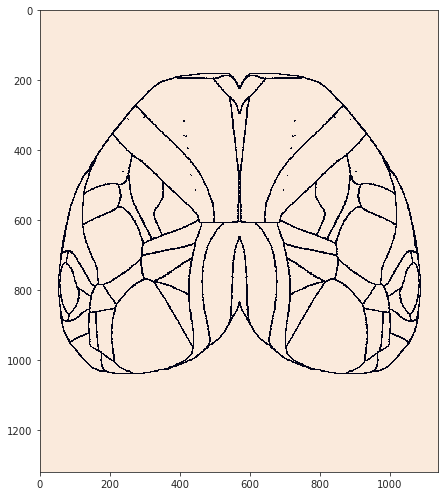

In [42]:
x = sp_img.gaussian_filter(affil['obj_top'], sigma=0.)
x = x.astype(float)
x = sp_img.gaussian_filter(x, sigma=0.15)

contour = ~np.logical_or(
    sp_img.sobel(x, axis=0),
    sp_img.sobel(x, axis=1),
)

fig, ax = create_figure(figsize=(10, 7))
plt.imshow(contour)